# **Chapter 5: Image restoration**

In this notebook, we study image denoising and deblurring. We will compare several denoising methods, namely, arithmetic/geometric mean, median, α-trimmed mean, an adaptive mean filter, and the bilateral filter. Then we move to deblurring using inverse (masked), Wiener, constrained least-squares, and Richardson–Lucy methods. Throughout, we use the image `watch.jpg` equalized for contrast and report the standard deviation of the reconstruction error $\sigma(I{-}\hat I)$ as a simple objective measure.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.exposure import equalize_hist

plt.rcParams['image.cmap']='gray'
plt.rcParams['figure.figsize']=[10,6]

In [2]:
I = io.imread('watch.jpg')
I = equalize_hist(I)

## Image denoising
In denoising, the aim is to remove image noise by using various of filters. The selection of the filter and its parameters depends on the noise characteristics. For example, median filter works well for impulse noise, but for Gaussian noise, which is a common model for image noise, it does not work so well as demonstrated in this section. 

### Image noise

We assume that our input image is noiseless. Therefore, we create some synthetic Gaussian noise that is added to the image. When using the default values in the `random_noise` function, the variance is 0.01 which means that the standard deviation is 0.1 (10% of the dynamic range). As a consequence, the level of noise is quite significant, as we can see below. We also convert the image to 8-bit precision with `img_as_ubyte` that causes some extra quantization noise.


In [3]:
from skimage.util import random_noise
from skimage import img_as_ubyte

In [4]:
J = random_noise(I,'gaussian')

In [5]:
J = img_as_ubyte(J)

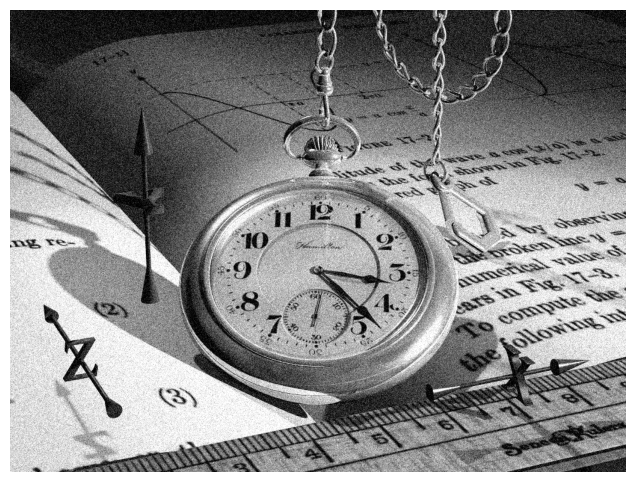

In [6]:
plt.imshow(J)
plt.axis('off');

### Arithmetic and geometric mean filters

First, we try to remove the noise by applying two $5\times5$ filters: the arithmetic mean (`filters.rank.mean`) and the geometric mean (`filters.rank.geometric_mean`). Both reduce Gaussian noise but also blur edges; the geometric mean can be more sensitive near low intensities.


In [7]:
from skimage import filters

In [8]:
A = filters.rank.mean(J,np.ones((5,5)))

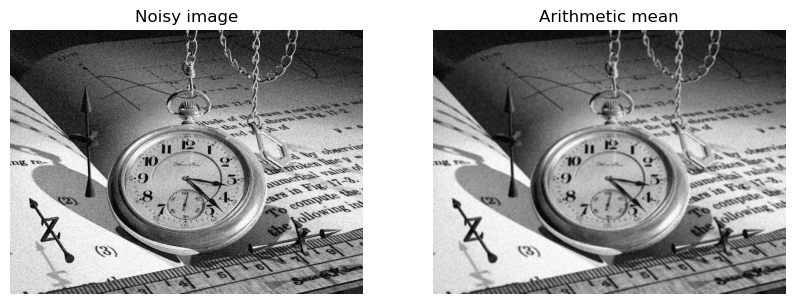

In [9]:
plt.subplot(1,2,1)
plt.imshow(J)
plt.title('Noisy image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(A)
plt.title('Arithmetic mean')
plt.axis('off');

In [10]:
G=filters.rank.geometric_mean(J,np.ones((5,5)))

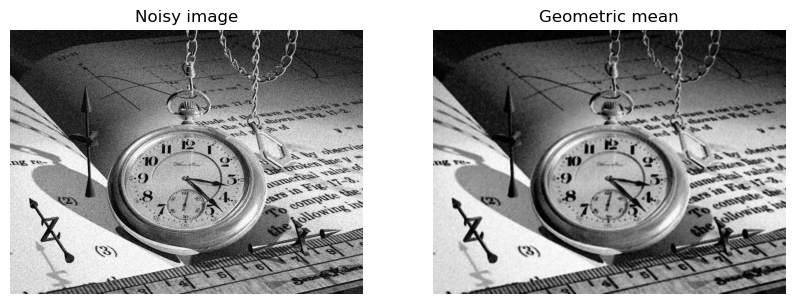

In [11]:
plt.subplot(1,2,1)
plt.imshow(J)
plt.title('Noisy image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(G)
plt.title('Geometric mean')
plt.axis('off');

### Median filter

A median filter is ideal for removing impulse (salt‑and‑pepper) noise and it also tends to preserve edges better than mean filters. However, as shown below, when applying a $5\times5$ median filter to our test image, its performance in noise removal is not effective, leaving visible residual grain and still introducing some blurring.

In [12]:
M = filters.rank.median(J,np.ones((5,5)))

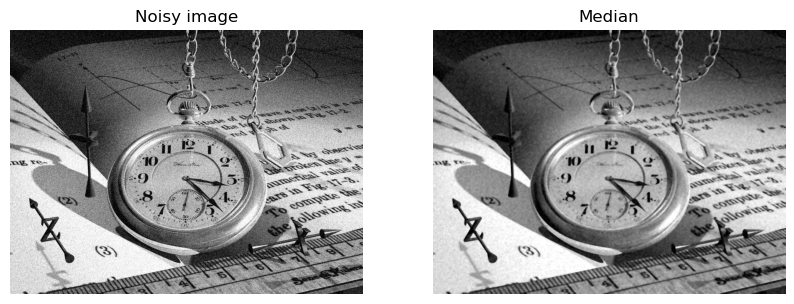

In [13]:
plt.subplot(1,2,1)
plt.imshow(J)
plt.title('Noisy image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(M)
plt.title('Median')
plt.axis('off');

### Alfa-trimmed mean filter

The $\alpha$‑trimmed mean (`filters.rank.mean_percentile`) discards a fraction of the lowest and highest samples before averaging (here $p_0=0.2$, $p_1=0.8$), offering a compromise between mean and median for robustness vs. smoothing. However, as seen below, the result is not much better than with the previous methods.


In [14]:
P=filters.rank.mean_percentile(J,np.ones((5,5)),p0=0.2,p1=0.8)

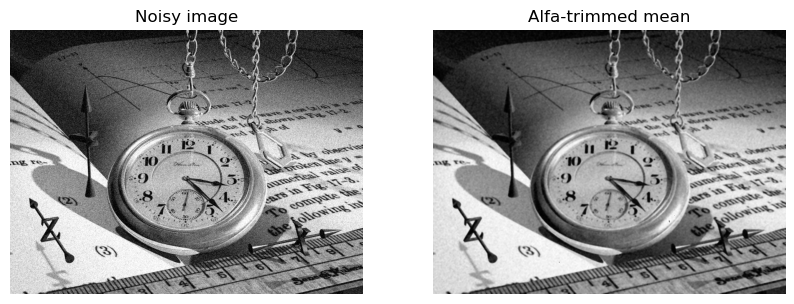

In [15]:
plt.subplot(1,2,1)
plt.imshow(J)
plt.title('Noisy image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(P)
plt.title('Alfa-trimmed mean')
plt.axis('off');


### Adaptive mean filter

The scikit-image package does not offer a built-in adaptive mean filter. However, we can easily implement one ourselves by following the algorithm presented in the lecture slides. This approach is effective at removing noise from areas without texture, while still preserving important image details.

Our implementation estimates the local mean $\mu$ and local variance $\sigma_L^2$ within an $n\times n$ window. The filter then attenuates the deviation from $\mu$ by a factor $r = \mathrm{clip}(\sigma_N^2/\sigma_L^2, 0, 1)$, where $\sigma_N^2$ represents the assumed noise variance. When using $n = 15$ and $\sigma_N^2 = 0.01$, the filter effectively removes noise from flat regions while preserving textures and edges.



In [16]:
from scipy.ndimage import convolve

def adaptive_filter(I, nvar, n):
    I = I.astype(float)/255
    filt = np.ones((n,n))/n/n
    mu = convolve(I,filt)
    lvar = convolve(I**2,filt) - mu**2
    r = np.clip(nvar/lvar,0,1)
    out = I - r*(I-mu)
    return out.clip(0,1)

In [17]:
A = adaptive_filter(J,0.01,15)

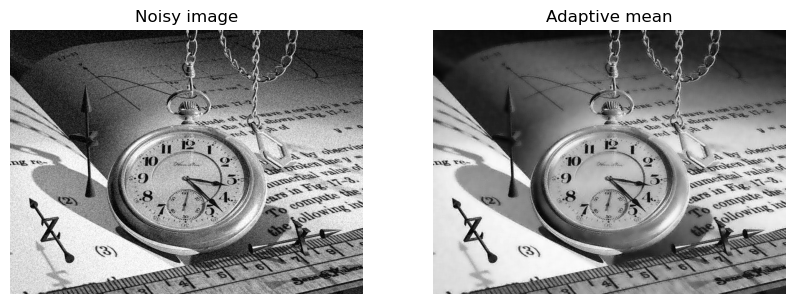

In [18]:
plt.subplot(1,2,1)
plt.imshow(J)
plt.title('Noisy image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(A)
plt.title('Adaptive mean')
plt.axis('off');

### Bilateral filter

[Bilateral filter](https://en.wikipedia.org/wiki/Bilateral_filter) is a widely used adaptive denoising technique that computes a weighted average of neighboring pixels, where the weights are determined by both spatial distance and intensity differences. This approach allows the bilateral filter to efficiently remove noise while preserving important details in the image.
Specifically, the bilateral filter (implemented as `denoise_bilateral`) smooths regions within an image but maintains edge sharpness by blending a spatial kernel with a range kernel. In this example, we use `win_size=11`, `sigma_color=0.1`, and `sigma_spatial=5`, which noticeably reduce noise without blurring the edges.



In [19]:
from skimage.restoration import denoise_bilateral

In [20]:
B = denoise_bilateral(J,win_size=11,sigma_color=0.1, sigma_spatial=5)

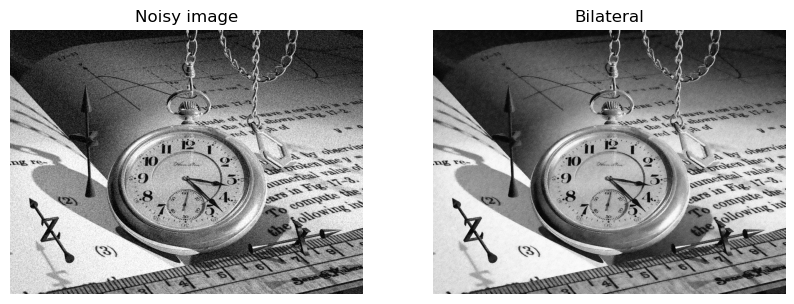

In [21]:
plt.subplot(1,2,1)
plt.imshow(J)
plt.title('Noisy image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(B)
plt.title('Bilateral')
plt.axis('off');

## Image deblurring
In image deblurring, the aim is to remove degradation that is caused by some linear and shift invariant source of perturbation. In this section, we use linear motion blur as an example.
### Motion blur
First, we simulate horizontal motion blur by creating a point spread function (PSF) that is, in this case, a horizontal line with the length of 15 pixels ( a $1\times15$ box filter). We also produce the blurred image by using frequency domain filtering so that $S=\mathcal F^{-1}\{H\,F\}$. The blurred image shows attenuated high frequencies and smeared edges, setting up the deblurring experiments. The aim is to remove this blur and restore the original image.

In [22]:
psf = np.ones((1,15))/15

In [23]:
F = np.fft.fft2(I)
H = np.fft.fft2(psf,I.shape)

In [24]:
S = np.fft.ifft2(H*F).real

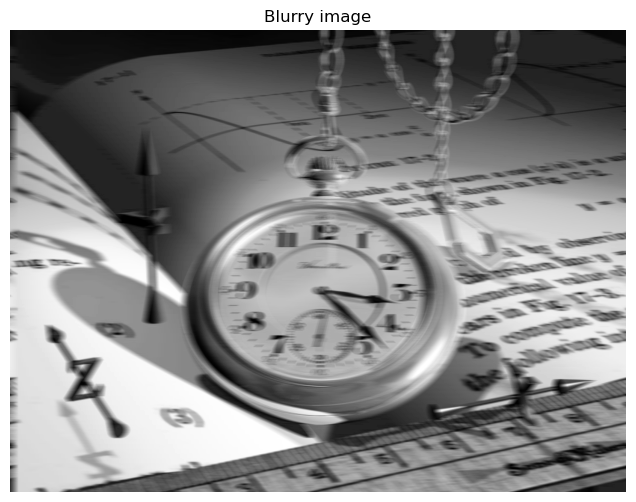

In [25]:
plt.imshow(S)
plt.title('Blurry image')
plt.axis('off');

### Inverse filter

Inverse filtering divides the observed spectrum by the PSF ($\hat F=G/H$). It is the simplest way of removing the blur, and as illustrated below, it works well, if there is no noise in the image.


In [26]:
G = np.fft.fft2(S)

In [27]:
Fe = G/H

In [28]:
R = np.fft.ifft2(Fe).real.clip(0,1)

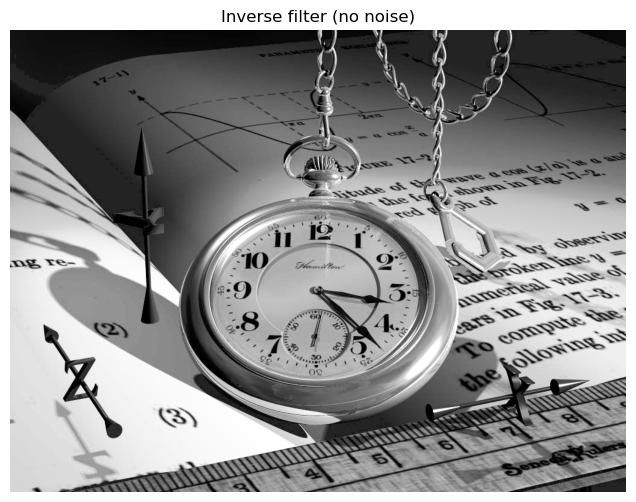

In [29]:
plt.imshow(R)
plt.title('Inverse filter (no noise)')
plt.axis('off');

### Inverse filtering of a noisy image
However, the situation changes dramatically even if unnoticeable amount of noise is introduced.

In [30]:
S = random_noise(S,'gaussian',var=0.0001)

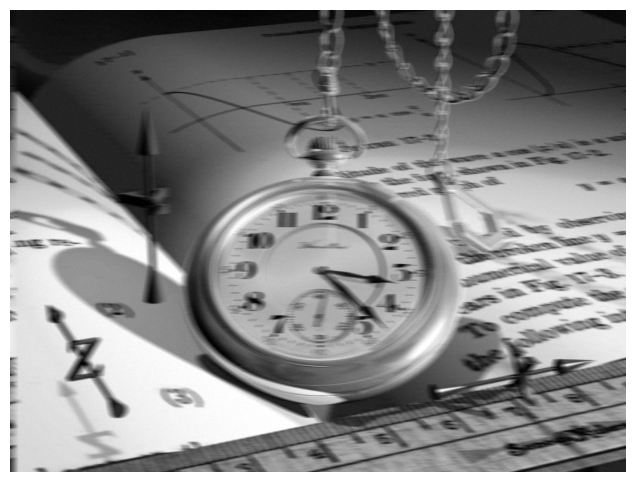

In [31]:
plt.imshow(S)
plt.axis('off');

In [32]:
G = np.fft.fft2(S)
Fe = G/H
R = np.fft.ifft2(Fe).real.clip(0,1)

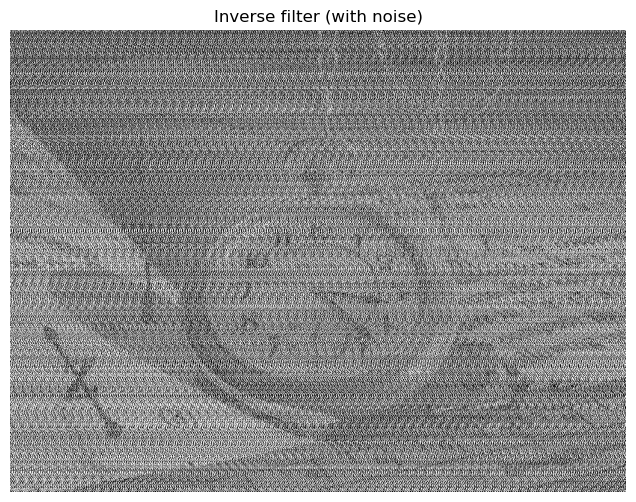

In [33]:
plt.imshow(R)
plt.title('Inverse filter (with noise)')
plt.axis('off');

This happens, because the high-frequency coefficients have small values and in inverse filtering they are divided by values that are also close to zero, which makes them very sensitive to noise. To deal with this issue, we can limit the effect of filtering only to low-frequency coefficients and the remaining high-frequency coefficients are kept unchanged. To this end, we create the following mask, which has the frequency response of an ideal low-pass filter.

In [34]:
m,n = I.shape
u0 = np.fft.fftfreq(n)
v0 = np.fft.fftfreq(m)
u,v = np.meshgrid(u0,v0)

In [35]:
mask = u**2 + v**2 < 0.1**2

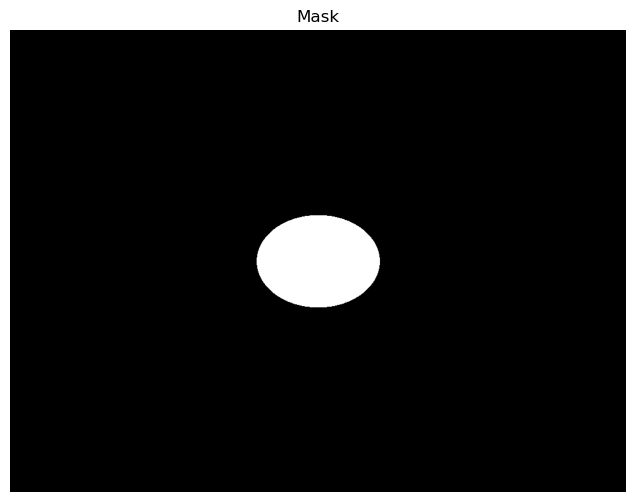

In [36]:
plt.imshow(np.fft.fftshift(mask))
plt.title('Mask')
plt.axis('off');

Then, we perform inverse filtering only for those coefficients that are within the pass-band. However, there is a significant ringing effect in the result as shown below.

In [37]:
Fe = np.copy(G)
Fe[mask] = Fe[mask]/H[mask]

In [38]:
R = np.fft.ifft2(Fe).real.clip(0,1)

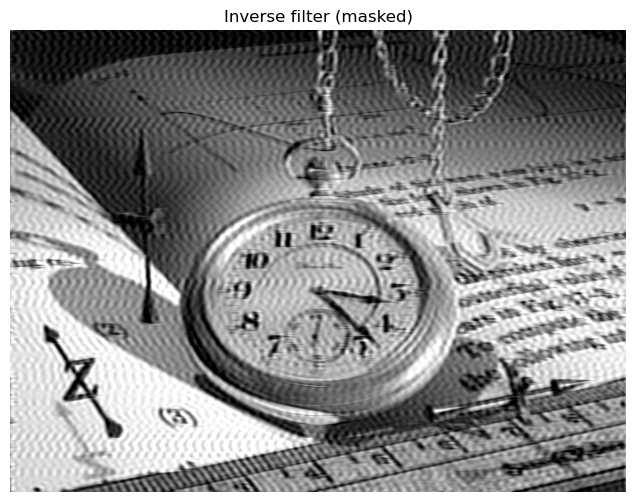

In [39]:
plt.imshow(R)
plt.title('Inverse filter (masked)')
plt.axis('off');

As a simple quantitative check, we compute the standard deviation of the pixelwise difference between the ground truth and the reconstruction, $\sigma(I{-}R)$. Lower values indicate better restoration on this dataset.


In [40]:
(I-R).std()

0.09329298535771761

We also report $\sigma(I{-}S)$ for the blurred input $S$ to contextualize whether the restoration actually improves upon the degraded image. This comparison shows that there is not much improvement.


In [41]:
(I-S).std()

0.13515825436241508

### Wiener filter
Wiener filter is another simple and well-know statistical approach for image restoration. It balances inversion and noise suppression via $\hat F=\frac{H^*}{|H|^2+k}\,G$ (here implemented as $\frac{|H|^2}{|H|^2+k}\frac{G}{H}$). The purpose of $k$ is to approximate the ratio between the power spetrums of the noise and the original image. In practice, this constant is often selected experimentally. With $k=0.005$, we can see that it clearly reduces ringing and noise amplification compared to plain inverse filtering.


In [42]:
k = 0.005

In [43]:
Fe = 1/H*np.abs(H)**2/(np.abs(H)**2+k)*G

In [44]:
R = np.fft.ifft2(Fe).real.clip(0,1)

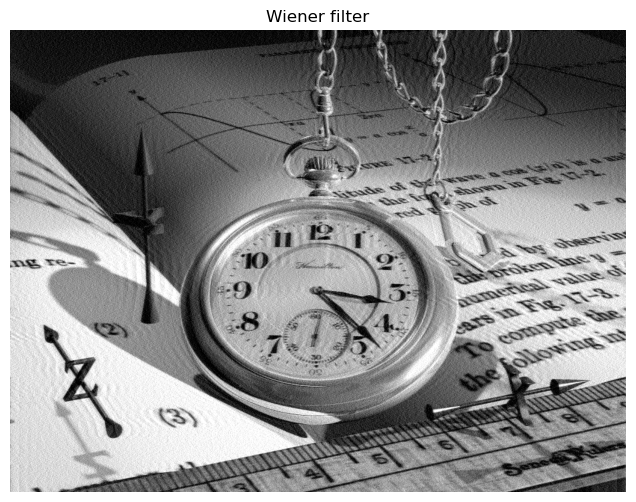

In [45]:
plt.imshow(R)
plt.title('Wiener filter')
plt.axis('off');

This is also confirmed by the standard deviation $\sigma(I{-}R)$ that is lower than for the masked inverse filter.


In [46]:
(I-R).std()

0.06775191178627483

### Constrained least squares filter

The third method presented in the lecture is constrained least squares that uses a smoothness prior enforced by the Laplacian; in the frequency domain $\hat F=\dfrac{H^*}{|H|^2+\gamma|L|^2}G$ with $L(u,v)=-(u^2+v^2)$. Again there is one parameter denoted by $\gamma$ which needs to be determined, and often it is done experimentally. In the following, we use $\gamma=2$.


In [47]:
gamma = 2

In [48]:
L = -(u**2+v**2)

In [49]:
F = np.conj(H)/(np.abs(H)**2+gamma*np.abs(L)**2)*G

In [50]:
R = np.fft.ifft2(F).real.clip(0,1)

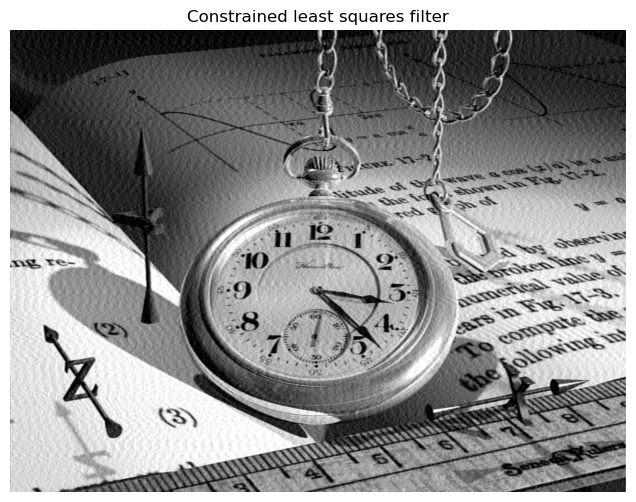

In [51]:
plt.imshow(R)
plt.title('Constrained least squares filter')
plt.axis('off');

In this case, there is more ringing effect in the output, but in terms of the standard deviation $\sigma(I{-}R)$ the result is slightly better than with the Wiener filter.


In [52]:
(I-R).std()

0.04977881116473258

### Richardson-Lucy

[The Richardson–Lucy algorithm](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution) is an iterative procedure for restoring images that have been blurred by a known point spread function. Although this method is not discussed in the lecture, it is widely used and available in `scikit-image`, so we demonstrate its performance here. The algorithm performs iterative maximum-likelihood deconvolution using the PSF and can recover sharp details; however, it is sensitive to noise and the number of iterations. In this case, with the default settings, the visual and quantitative performance is not as good as with the previous regularized frequency-domain methods.


In [53]:
from skimage.restoration import richardson_lucy

In [54]:
RL = richardson_lucy(S, psf)

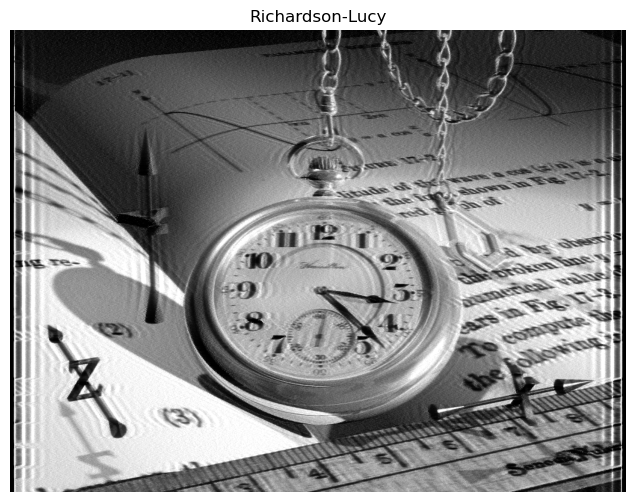

In [55]:
plt.imshow(RL)
plt.title('Richardson-Lucy')
plt.axis('off');

In [56]:
(I-RL).std()

0.19340402109787197